In [1]:
from utils import *

Setup_environment()

from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose

model_2D ='./detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
weights_2D = './detectron/checkpoint/model_final_997cc7.pkl'
model_3D = './VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

pose2d = Wrapper_2Dpose(model=model_2D, weights= weights_2D , ROI_thr=0.75)
pose_3d = Wrapper_3Dpose(model_3D)

config  = load_config()
print(config['video_object'])

./data/videos/remastered_omco_pickingup_1 (video-converter.com).mp4


In [2]:
video_object = Video_wrapper(config['video_object'], resize_video_by=0.3) #, start=0, end=10) # downsample_fps_by=2,
data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)

Frame 0 processed in 1.188s
Frame 1 processed in 0.068s
Frame 2 processed in 0.103s
Frame 3 processed in 0.067s
Frame 4 processed in 0.066s
Frame 5 processed in 0.060s
Frame 6 processed in 0.058s
Frame 7 processed in 0.062s
Frame 8 processed in 0.060s
Frame 9 processed in 0.058s
Frame 10 processed in 0.057s
Frame 11 processed in 0.063s
Frame 12 processed in 0.059s
Frame 13 processed in 0.059s
Frame 14 processed in 0.057s
Frame 15 processed in 0.062s
Frame 16 processed in 0.058s
Frame 17 processed in 0.058s
Frame 18 processed in 0.058s
Frame 19 processed in 0.062s
Frame 20 processed in 0.058s
Frame 21 processed in 0.060s
Frame 22 processed in 0.059s
Frame 23 processed in 0.060s
Frame 24 processed in 0.060s
Frame 25 processed in 0.058s
Frame 26 processed in 0.057s
Frame 27 processed in 0.060s
Frame 28 processed in 0.058s
Frame 29 processed in 0.058s
Frame 30 processed in 0.058s
Frame 31 processed in 0.059s
Frame 32 processed in 0.066s
Frame 33 processed in 0.058s
Frame 34 processed in 0.

In [3]:
from tensor_ergonomics import RULAXXX
original_pose = torch.tensor(data_3d)

pose = original_pose.clone().detach().requires_grad_(True)
print(pose.requires_grad)

rula_eval = RULAXXX(pose)

scores = rula_eval.compute_scores()
print(scores.requires_grad)

#rula_eval.plot_scores(fps=video_object.fps)

True
Angles: <class 'torch.Tensor'>
--- Frame 0: ---
Frame: tensor([ 14.3200, 111.9615,  36.7538, 119.7843,  29.0617,  43.0275,   9.8064,
         23.7113,  14.8478,   1.2035,  91.7161,  35.1584,  99.9522,  98.7746])
Max shoulder: tensor(36.7538)
Max abduction: tensor(119.7843)
Max elbow: tensor(43.0275)
Score Upper Arm: tensor([2.])
Score Lower Arm: tensor([1.])
Current Score A: tensor(2.)
Score Neck: tensor([1.])
Score Trunk: tensor([1.])
Min knee: tensor(9.8064)
Score Legs: tensor([1.])
Current Score B: tensor(1.)
Current Total Score: tensor(2.)
--- Frame 1: ---
Frame: tensor([ 13.3871, 111.5931,  36.6162, 119.9958,  28.3456,  43.2193,  10.3814,
         24.7142,  14.8867,   0.9492,  91.6003,  35.7412,  99.8162,  98.4799])
Max shoulder: tensor(36.6162)
Max abduction: tensor(119.9958)
Max elbow: tensor(43.2193)
Score Upper Arm: tensor([2., 2.])
Score Lower Arm: tensor([1., 1.])
Current Score A: tensor(2.)
Score Neck: tensor([1., 1.])
Score Trunk: tensor([1., 1.])
Min knee: tensor(10.

In [4]:
scores[0]

tensor(2.)

## Pose Optim  Loop

In [10]:
import torch
from tensor_ergonomics import RULAXXX

def run_pose_optimization(original_pose, num_steps=300):
    """
    Optimize the pose using the RULA score.
    
    Parameters:
    - original_pose: A tensor of shape (17, 3)
    
    Returns:
    - Optimized pose.
    """

    # Ensure the original_pose is a tensor
    if not isinstance(original_pose, torch.Tensor):
        original_pose = torch.tensor(original_pose)

    original_pose = original_pose.clone().detach().requires_grad_(True)

    # Define an optimizer. Here, we use the Adam optimizer.
    optimizer = torch.optim.Adam([original_pose], lr=0.01) #(1,200t, 17, 3)

    for step in range(num_steps):
        optimizer.zero_grad()

        # Convert the tensor to the format expected by RULA (ndarray)
        #pose_for_rula = pose.detach().cpu().numpy()

        # Compute the RULA score for the current pose            
        rula_eval = RULAXXX(original_pose)
        rula_score = rula_eval.compute_scores()
        print(rula_score.requires_grad)
        ergo_sum = rula_score.sum()
        print(ergo_sum.requires_grad)

        # Convert the RULA score back to a tensor
        #rula_score_tensor = torch.tensor(ergo_sum, dtype=torch.float32)

        # We want to minimize the RULA score, so we negate it for optimization
        loss = ergo_sum

        # Backpropagate the loss
        loss.backward()

        # Update the pose
        optimizer.step()

        # Print the RULA score every 50 steps
        if step % 50 == 0:
            print(f"Step {step}: RULA Score: {ergo_sum.item()}")

    return pose



optimized_pose = run_pose_optimization(data_3d)


Angles: <class 'torch.Tensor'>
--- Frame 0: ---
Frame: tensor([ 14.3200, 111.9615,  36.7538, 119.7843,  29.0617,  43.0275,   9.8064,
         23.7113,  14.8478,   1.2035,  91.7161,  35.1584,  99.9522,  98.7746])
Max shoulder: tensor(36.7538)
Max abduction: tensor(119.7843)
Max elbow: tensor(43.0275)
Score Upper Arm: tensor([2.])
Score Lower Arm: tensor([1.])
Current Score A: tensor(2.)
Score Neck: tensor([1.])
Score Trunk: tensor([1.])
Min knee: tensor(9.8064)
Score Legs: tensor([1.])
Current Score B: tensor(1.)
Current Total Score: tensor(2.)
--- Frame 1: ---
Frame: tensor([ 13.3871, 111.5931,  36.6162, 119.9958,  28.3456,  43.2193,  10.3814,
         24.7142,  14.8867,   0.9492,  91.6003,  35.7412,  99.8162,  98.4799])
Max shoulder: tensor(36.6162)
Max abduction: tensor(119.9958)
Max elbow: tensor(43.2193)
Score Upper Arm: tensor([2., 2.])
Score Lower Arm: tensor([1., 1.])
Current Score A: tensor(2.)
Score Neck: tensor([1., 1.])
Score Trunk: tensor([1., 1.])
Min knee: tensor(10.3814)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

<class 'torch.Tensor'>
i : 0
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 1
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 2
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 3
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 4
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 5
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 6
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 7
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.) tensor(5.)
i : 8
Max shoulder, score_upper_arm[i]:  tensor(10.) ,  tensor(1.)
Current score A B :  tensor(1.

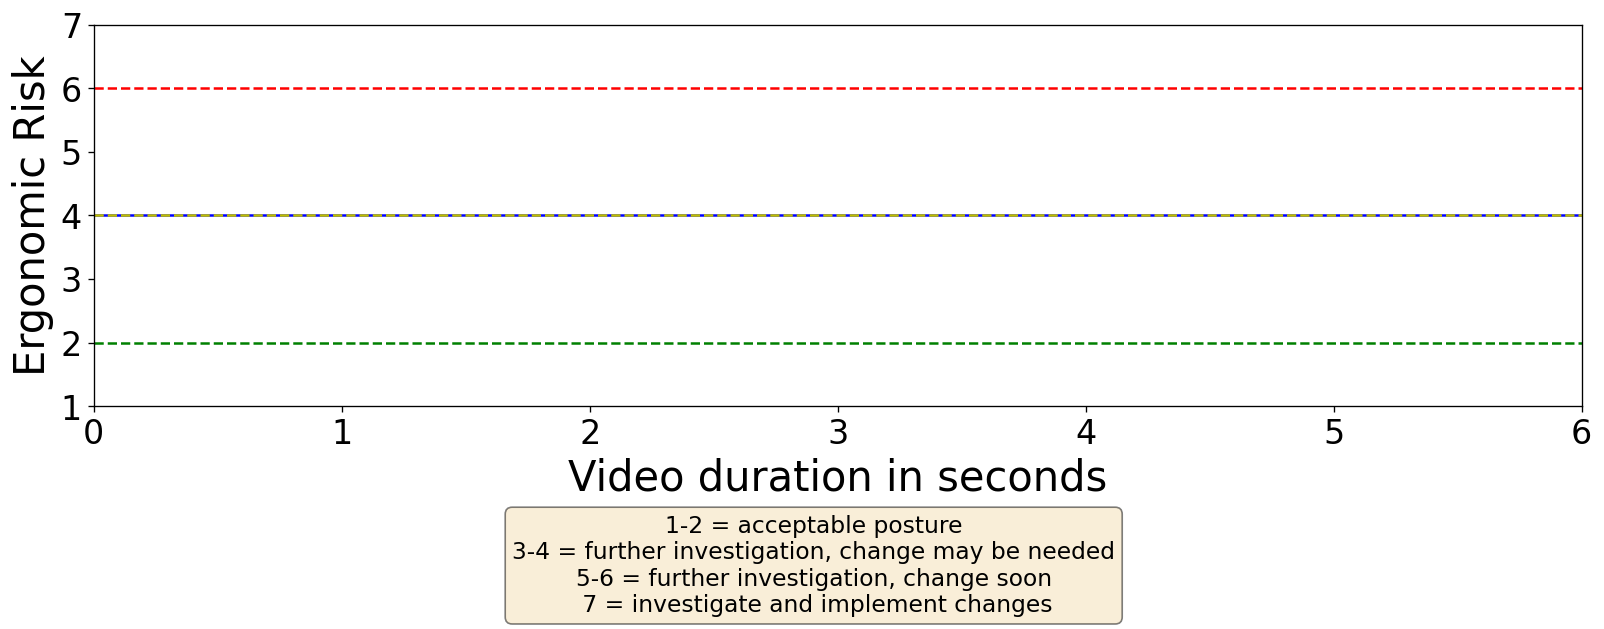

In [4]:
from ergonomics_torch import RULATorch

# Ensure the original_pose is a tensor
if not isinstance(data_3d, torch.Tensor):
    original_pose = torch.tensor(data_3d)

pose = original_pose.clone().detach().requires_grad_(True)

rula_eval = RULATorch(original_pose)
print(type(original_pose))
scores = rula_eval.compute_scores()

rula_eval.plot_scores(fps=video_object.fps)

In [ ]:
import torch
from torch.autograd import Function
from ergonomics import RULA

def run_pose_optimization(original_pose, num_steps=300):
    """
    Optimize the pose using the RULA score.
    
    Parameters:
    - original_pose: A tensor of shape (17, 3)
    
    Returns:
    - Optimized pose.
    """

    # Ensure the original_pose is a tensor
    if not isinstance(original_pose, torch.Tensor):
        original_pose = torch.tensor(original_pose)

    pose = original_pose.clone().detach().requires_grad_(True)

    # Define an optimizer. Here, we use the Adam optimizer.
    optimizer = torch.optim.Adam([pose], lr=0.01)

    for step in range(num_steps):
        optimizer.zero_grad()

        # Compute the RULA score for the current pose using the custom function
        rula_score_tensor = RULALossFunction.apply(pose)

        # We want to minimize the RULA score, so we negate it for optimization
        loss = -rula_score_tensor

        # Backpropagate the loss
        loss.backward()

        # Update the pose
        optimizer.step()

        # Print the RULA score every 50 steps
        if step % 50 == 0:
            print(f"Step {step}: RULA Score: {rula_score_tensor.item()}")

    return pose

original_pose = data_dict['kps'][:1,::][0]
original_pose_tensor = torch.tensor(original_pose, dtype=torch.float32, requires_grad=True)
print(original_pose_tensor.shape) #torch.Size([17, 3])
optimized_pose = run_pose_optimization(original_pose_tensor)


In [8]:
import torch
from tensor_ergonomics import RULAXXX

def run_pose_optimization(original_pose, num_steps=300):
    """
    Optimize the pose using the RULA score.
    
    Parameters:
    - original_pose: A tensor of shape (17, 3)
    
    Returns:
    - Optimized pose.
    """

    # Initialize the pose to be optimized
    pose = original_pose.clone().detach().requires_grad_(True)

    # Define an optimizer. Here, we use the Adam optimizer.
    optimizer = torch.optim.Adam([pose], lr=0.01)

    for step in range(num_steps):
        optimizer.zero_grad()

        # Compute the RULA score for the current pose            
        rula_eval = RULAXXX(original_pose)
        print(rula_eval)
        rula_score = rula_eval.compute_scores()
        
        # We want to minimize the RULA score, so we negate it for optimization
        loss = -rula_score

        # Backpropagate the loss
        loss.backward()

        # Update the pose
        optimizer.step()

        # Print the RULA score every 50 steps
        if step % 50 == 0:
            print(f"Step {step}: RULA Score: {rula_score.item()}")

    return pose


# Optimize the pose
original_pose = data_3d
original_pose_tensor = torch.tensor(original_pose, dtype=torch.float32, requires_grad=True)
print(original_pose_tensor.shape) #torch.Size([17, 3])
optimized_pose = run_pose_optimization(original_pose_tensor)


torch.Size([168, 17, 3])
Angles: <class 'torch.Tensor'>
--- Frame 0: ---
Frame: tensor([ 14.3200, 111.9615,  36.7538, 119.7843,  29.0617,  43.0275,   9.8064,
         23.7113,  14.8478,   1.2035,  91.7161,  35.1584,  99.9522,  98.7746])
Max shoulder: tensor(36.7538)
Max abduction: tensor(119.7843)
Max elbow: tensor(43.0275)
Score Upper Arm: tensor([2.])
Score Lower Arm: tensor([1.])
Current Score A: tensor(2.)
Score Neck: tensor([1.])
Score Trunk: tensor([1.])
Min knee: tensor(9.8064)
Score Legs: tensor([1.])
Current Score B: tensor(1.)
Current Total Score: tensor(2.)
--- Frame 1: ---
Frame: tensor([ 13.3871, 111.5931,  36.6162, 119.9958,  28.3456,  43.2193,  10.3814,
         24.7142,  14.8867,   0.9492,  91.6003,  35.7412,  99.8162,  98.4799])
Max shoulder: tensor(36.6162)
Max abduction: tensor(119.9958)
Max elbow: tensor(43.2193)
Score Upper Arm: tensor([2., 2.])
Score Lower Arm: tensor([1., 1.])
Current Score A: tensor(2.)
Score Neck: tensor([1., 1.])
Score Trunk: tensor([1., 1.])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
data_3d